In [1]:
from os import chdir
chdir('..')

In [52]:
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
import matplotlib
import math
import seaborn as sns
import pandas as pd
import numpy as np
from polylidar import extractPlanesAndPolygons
from shapely.geometry import LineString, asPolygon
from shapely.affinity import scale, translate
from os import path
from concave_evaluation.helpers import fake_building, plot_line, BLUE, GRAY, plot_arrow, scale_axes, plot_poly, load_polygon, get_max_bounds_polys, measure_convexity_simple
%matplotlib inline
sns.set(font_scale=1)  # crazy big


## Subtimings

These are the timings for all concave hull extraction algorithms which have a triangulation step. I'm only comparing subtimings for these algorithms together because its (somewhat) easier to compare or relate substeps of the algorithms. Though they do not line up perfectly.

### CGAL


**Triangulation** - Uses CGAL Delaunay Triangulation. Uses CGAL methods for robust geometric predicates.

**Shape Creation** - Filters triangle faces, edges, and vertices by the alpha radius. It also classifies each of these objects. Datastructures to find the triangles, edges, and vertices of the alpha shape are created. The interval of the alpha shape for each of these strcutures is created to allow fast creation of a **family** of alpha shapes.

**Polygon Extraction** - None. An output of CGAL Alpha shapes is simply an the unordered list of edges of the alpha shapes. It is possible to turn this into a polgygon but no implementation that I know of is provided by CGAL. Such an implementation will also need to handle the creation of mulitpolygon output as well as holes inside individual polygons as perfomed by both Polylidar and Spatialite.

### Polylidar 


**Triangulation** - Uses Delaunator for triangulation. Uses adaptive floating point arithmetic for robust geometric predicates from https://www.cs.cmu.edu/~quake/robust.html.

**Shape Extraction** - Filters triangles by alpha radius. Executes region growing which creates disparate sets of spatially connected triangles. Each set is called a region (called planes in 3D). 

**Polygon Extraction** - For each region, the polygonal representaton is extracted. This occurs by identifying boundary edges, choosing a starting edge on the hull, carefully walking the hull (handle edge cases when hole edges and border edges share vertices), and finally forming a linear ring representing the exterior hull. Interior holes are also extracted (once again, carefully handling edge cases).

### Spatialite

**Triangulation** - Uses GEOS to perform triangulation. Uses robust geometric predicated built into GEOS.

**Shape Extraction** - Compute edge length statistics of all triangle edges, prudcing a $\mu_l$ and $\sigma_l$. Filters any triangle who has an edge $l > \mu_l + factor \cdot \sigma_l$ 

**Polygon Extraction** - Uses GEOS to compute the union of all triangles to generate the polygonal representation of the the all remaining triangles.  

In [53]:
# These timings were exectued on my computer, 30 samples for each algorithm
# Please see readme if you desire to reproduce these subtimings
timings_cgal = [[46.862,160.001],[44.394,158.039],[44.468,152.339],[44.405,152.891],[44.374,152.626],[44.388,154.035],[44.466,153.964],[44.466,153.671],[44.389,153.933],[44.36,152.299],[44.444,153.398],[44.37,153.527],[44.357,153.021],[44.384,154.086],[44.462,153.508],[44.59,153.483],[44.444,153.228],[44.539,154.614],[44.462,152.466],[44.363,153.76],[44.449,154.291],[44.472,154.772],[44.573,152.665],[44.726,154.413],[44.477,154.577],[44.494,155.103],[44.508,155.043],[44.474,153.003],[44.53,153.702],[44.4,154.183]]
timings_polylidar = [[36.12799835205078, 4.36299991607666, 0.9810000061988831], [35.928001403808594, 4.394000053405762, 1.027999997138977], [36.665000915527344, 4.3470001220703125, 1.059000015258789], [35.79399871826172, 4.316999912261963, 0.9760000109672546], [35.8390007019043, 4.35699987411499, 1.1080000400543213], [36.36899948120117, 4.396999835968018, 0.9990000128746033], [35.97100067138672, 4.35699987411499, 0.9700000286102295], [35.84700012207031, 4.359000205993652, 0.9929999709129333], [35.72999954223633, 4.355000019073486, 0.9779999852180481], [35.779998779296875, 4.335999965667725, 0.9580000042915344], [36.327999114990234, 4.354000091552734, 0.9649999737739563], [35.77000045776367, 4.429999828338623, 0.9819999933242798], [36.29100036621094, 4.381999969482422, 0.972000002861023], [36.444000244140625, 4.3470001220703125, 0.9639999866485596], [35.87900161743164, 4.372000217437744, 0.9879999756813049], [35.93000030517578, 4.382999897003174, 0.9760000109672546], [35.95600128173828, 4.414999961853027, 0.9729999899864197], [36.525001525878906, 4.375999927520752, 0.9789999723434448], [35.819000244140625, 4.373000144958496, 0.9829999804496765], [36.13800048828125, 4.375999927520752, 0.9769999980926514], [36.43600082397461, 4.366000175476074, 0.9679999947547913], [35.79999923706055, 4.392000198364258, 0.9700000286102295], [35.6879997253418, 4.366000175476074, 0.9860000014305115], [35.70100021362305, 4.372000217437744, 0.9879999756813049], [36.05099868774414, 4.34499979019165, 0.9679999947547913], [35.75400161743164, 4.3379998207092285, 0.972000002861023], [36.01100158691406, 4.3470001220703125, 0.9679999947547913], [35.724998474121094, 4.35099983215332, 0.9810000061988831], [36.13600158691406, 4.339000225067139, 0.9700000286102295], [36.02899932861328, 4.368000030517578, 0.9879999756813049]]
timings_spatialite = [[243.2134,128.8915,10360.2976],[227.9394,130.3733,10390.0784],[227.4224,134.5224,10378.9729],[224.1232,129.1779,10553.6631],[238.2201,137.2343,10890.5426],[229.3539,135.3008,10517.0301],[228.7435,130.1042,10465.4918],[231.9369,130.8360,10482.0692],[227.3919,132.8230,10459.4602],[227.2898,133.1695,10500.2744],[226.9457,131.7726,10611.0244],[237.7284,134.2110,10911.7942],[234.5558,138.6091,10921.2371],[236.4156,137.5632,10925.5706],[239.3039,138.8017,10912.7750],[230.0623,137.1160,10923.9332],[237.9716,140.4151,10932.0248],[237.7439,137.0150,10913.0082],[238.0106,135.7160,11105.2319],[240.1162,137.9742,11188.3114],[238.8588,137.1617,11084.2021],[236.3043,135.8150,10873.0050],[235.1310,135.2349,10900.7403],[234.9856,137.3502,10921.8185],[236.2775,135.5974,10916.4996],[234.9958,132.2554,10902.1786],[235.7370,136.4068,10923.0945],[238.3606,138.1947,10927.9517],[232.7049,141.2146,10924.7551],[236.9476,137.6959,10942.4811]]

In [56]:
df_cgal = pd.DataFrame(timings_cgal, columns=['triangulation', 'shape extraction'])
df_cgal['polygon extraction'] =  np.nan # CGAL does not produce a polygon, only the *shape*
df_cgal['algorithm'] = 'cgal'

df_pl = pd.DataFrame(timings_polylidar, columns=['triangulation', 'shape extraction', 'polygon extraction'])
df_pl['algorithm'] = 'polylidar'

df_sl = pd.DataFrame(timings_spatialite, columns=['triangulation', 'shape extraction', 'polygon extraction'])
df_sl['algorithm'] = 'spatialite'

df = pd.concat([df_pl, df_cgal, df_sl], axis=0)

df_melt = pd.melt(df,
               id_vars=['algorithm'], value_vars=['triangulation', 'shape extraction', 'polygon extraction'],
               value_name='time', var_name='Section')
df_melt
df

,triangulation,shape extraction,polygon extraction,algorithm
0,36.127998,4.3630,0.9810,polylidar
1,35.928001,4.3940,1.0280,polylidar
2,36.665001,4.3470,1.0590,polylidar
3,35.793999,4.3170,0.9760,polylidar
4,35.839001,4.3570,1.1080,polylidar
...,...,...,...,...
25,234.995800,132.2554,10902.1786,spatialite
26,235.737000,136.4068,10923.0945,spatialite
27,238.360600,138.1947,10927.9517,spatialite
28,232.704900,141.2146,10924.7551,spatialite


[None]

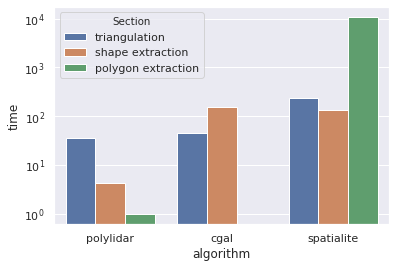

In [51]:
ax = sns.barplot(x="algorithm", y="time",
            hue="Section", data=df_melt)
ax.set(yscale="log")

In [57]:
# df.groupby('algorithm').mean(['triangulation', 'shape extraction', 'polygon extraction'])
# df.groupby('algorithm').mean()
column_order = ['polylidar', 'cgal', 'spatialite']
result = df.groupby('algorithm').agg({'triangulation':['mean','max'],
                             'shape extraction':['mean', 'max'], 
                             'polygon extraction':['mean', 'max']})
result = result.reindex(column_order, axis=0)
result

triangulation             shape extraction            \
                    mean         max             mean       max   
algorithm                                                         
polylidar      36.015400   36.665001         4.365800    4.4300   
cgal           44.536333   46.862000       154.021367  160.0010   
spatialite    234.159720  243.213400       135.285113  141.2146   

           polygon extraction              
                         mean         max  
algorithm                                  
polylidar            0.985600      1.1080  
cgal                      NaN         NaN  
spatialite       10788.650587  11188.3114

In [58]:
print(result.to_latex(escape=False, float_format="%.1f"))

\begin{tabular}{lrrrrrr}
\toprule
{} & \multicolumn{2}{l}{triangulation} & \multicolumn{2}{l}{shape extraction} & \multicolumn{2}{l}{polygon extraction} \\
{} &          mean &   max &             mean &   max &               mean &     max \\
algorithm  &               &       &                  &       &                    &         \\
\midrule
polylidar  &          36.0 &  36.7 &              4.4 &   4.4 &                1.0 &     1.1 \\
cgal       &          44.5 &  46.9 &            154.0 & 160.0 &                NaN &     NaN \\
spatialite &         234.2 & 243.2 &            135.3 & 141.2 &            10788.7 & 11188.3 \\
\bottomrule
\end{tabular}

